In [19]:
import pandas as pd
from utils import config
from utils.bert.data import *

from sklearn.model_selection import train_test_split

config.xls_path = '../Train-Data/Mix6_mainCat_new/pro_review.xlsx'
# config.xls_path = '/home/eagleuser/Users/leyan/Train-Data/Mix6_mainCat_new/pro_review.xlsx'

total_df = pd.read_excel(config.xls_path)
# total_df = total_df[total_df['review_len']>=50]
# total_df = total_df[total_df['summary_len']>=5]
total_df = total_df.sort_values(by=['review_len','overlap'], ascending = False)
train_df, val_df = train_test_split(total_df, test_size=0.1, 
                                    random_state=0, shuffle=True)
vocab = Vocab()
tokenizer = vocab.tokenizer

print(len(total_df))
print(len(train_df))
print(len(val_df))

vocab_file ../temp/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
{'BOS': 1, 'EOS': 2, 'PAD': 0, 'EOQ': 3, 'SEP': 102, 'CLS': 101, 'UNK': 100}
459654
413688
45966


In [2]:
def longest_common_subsequence(main_string, comparing_string):

#     main_string = main_string.split(" ")
#     comparing_string = comparing_string.split(" ")
    columns_length = len(main_string)  # Get the length of the first word or base word
    rows_length = len(comparing_string)  # Get the length of the second word or comparing word

    # MAKE A 2D LIST (MATRIX)
    dynamic_table = [[0] * (columns_length + 1) for i in range(rows_length + 1)]

    # rows_length = NUMBER OF ROWS
    # columns_length = NUMBER OF COLUMNS
    
    # FILL THE MATRIX FOLLOWING LCS ALGORITHM.
    for i in range(1, rows_length + 1):
        for j in range(1, columns_length + 1):
            if main_string[j - 1] == comparing_string[i - 1]:
                dynamic_table[i][j] = 1 + dynamic_table[i - 1][j - 1]

            else:
                dynamic_table[i][j] = max(dynamic_table[i - 1][j], dynamic_table[i][j - 1])

#     print("MATRIX ACCORDING TO LONGEST COMMON SUBSEQUENCE ALGORITHM: \n ")

    # for i in range(rows_length + 1):
    #     print(dynamic_table[i])

    #print("LENGTH OF LONGEST COMMON SUBSEQUENCE = ", dynamic_table[rows_length][columns_length])

    len_lcs = dynamic_table[rows_length][columns_length]

    i = len(comparing_string)
    j = len(main_string)

    lcs_string = str()

    # BACKTRACKING TO FIND THE LONGEST COMMON SUBSEQUENCE

    temp = True

    while temp is True:
        if dynamic_table[i][j] == 0:
            temp = False
        elif dynamic_table[i][j] == dynamic_table[i][j - 1]:
            j = j - 1

        else:
            lcs_string = main_string[j-1] + " " + lcs_string
            i = i - 1
            j = j - 1

    return lcs_string, len_lcs

In [3]:
# df.loc[i,'token_lcs'] = token_lcs
#             df.loc[i,'len_lcs'] = len_lcs
#             df.loc[i,'percent_lcs'] = percent_lcs
#             df.loc[i,'overlap_pos'] = overlap_pos
            
#             df.loc[i,'reveiw_len'] = len(rev_tokens)
#             df.loc[i,'summary_len'] = len(summary_tokens)

In [4]:
#%%
from tqdm import tqdm
from copy import deepcopy
def analay(df, mode):
    
    df['token_lcs'] = 0
    df['len_lcs'] = 0
    df['percent_lcs'] = 0
    df['overlap_pos'] = 0

    df['reveiw__len'] = 0
    df['summary_len'] = 0
#     df = df[:100]
    with tqdm(total=len(df)) as pbar:
        for i ,row in df.iterrows():       
            overlap_pos = None

            rev, summary = row['review'], row['summary']
            rev_tokens, summary_tokens = tokenizer.tokenize(rev), tokenizer.tokenize(summary)            
            token_lcs, len_lcs = longest_common_subsequence(rev_tokens, summary_tokens)
            percent_lcs = len_lcs / len(summary_tokens) * 100 # percent

            rev_sents = rev.split(" . ")
            overlap_sents = {idx: longest_common_subsequence(tokenizer.tokenize(sent), summary_tokens) for idx, sent in enumerate(rev_sents)}
            sort_overlap_sent = {k:v for k,v in sorted(overlap_sents.items(), key= lambda item: item[1], reverse=True)}
            overlap_sent_id = list(sort_overlap_sent.items())[0][0]

            if (overlap_sent_id == 0) and (percent_lcs >= 20): overlap_pos = 0 # overlap_Top 
            elif (overlap_sent_id == len(rev_tokens)-1) and (percent_lcs >= 20): overlap_pos = 1 # overlap_Final 
            elif (percent_lcs >= 20): overlap_pos = 2 # overlap_other 
            else: overlap_pos = -1 # no overlap 

            df.loc[i,'token_lcs'] = token_lcs
            df.loc[i,'len_lcs'] = len_lcs
            df.loc[i,'percent_lcs'] = percent_lcs
            df.loc[i,'overlap_pos'] = overlap_pos
            
            df.loc[i,'reveiw_len'] = len(rev_tokens)
            df.loc[i,'summary_len'] = len(summary_tokens)
            pbar.update(1)
            pbar.set_description("%s row: %s | overlap_pos_bert: %s (%2.2f)percent_bert| len_lcs_bert: %s" % (mode, i, overlap_pos, percent_lcs, len_lcs))
    return df



In [5]:
train_df.head()

,review,summary,cheat,cheat_num,overlap,review_len,summary_len,POS_keys,DEP_keys,Noun_adj_keys,TextRank_keys
111637,the light look nice and fit together expect wi...,<s> charge port break on first charge attempt ...,"{'port', 'charge', 'break'}",3,4,89,9,"['', 'was', 'professional', 'charge', 'time', ...","['nice', 'light', 'port', 'time', 'first', 'oc...","['light', 'nice', 'packaging', 'professional',...","['try', 'gopro', 'board', 'review', 'read', 'r..."
402696,just had baby and want another just yet . cond...,<s> we try the magnum original and they were h...,"{'original', 'horrible', 'magnum', 'thick', 's...",5,14,71,19,"['', 'birth', 'married', 'right', 'couple', 'w...","['married', 'control', 'couple', 'tell', 'next...","['ideal', 'condom', 'couple', 'married', 'magn...","['control', 'way', 'condom']"
247159,had the red speedo ventilator duffle bag for f...,<s> speedo ventilator duffle bag is great love...,"{'ventilator', 'duffle', 'speedo', 'bag', 'love'}",5,6,51,10,"['report', 'happy', 'ventilation', 'shoe', 'qu...","['week', 'purchase', 'ventilator', 'duffle', '...","['report', 'week', 'ventilator', 'duffle', 're...","['speedo', 'ventilator', 'duffle', 'ventilation']"
239333,buy different brand sunglass for use the car b...,<s> they fit in the overhead sunglass holder o...,"{'fit', 'holder', 'overhead', 'car', 'sunglass'}",5,7,53,12,"['brand', 'buy', 'turn', 'glass', 'sunglass', ...","['brand', 'buy', 'turn', 'glass', 'sunglass', ...","['brand', 'use', 'glass', 'car', 'sunglass', '...","['different', 'brand', 'sunglass']"
172112,div class div input type hide name value class...,<s> easy to use and attach lens kit that allow...,"{'like', 'easy', 'lens', 'attach', 'phone', 'k...",7,12,328,24,"['unbiased', 'honest', 'review', '', '', 'time...","['unbiased', 'honest', 'review', 'influence', ...","['type', 'div', 'item', 'input', 'hide', 'name...","['clip', 'lens', 'kit', 'review', 'reviewer', ..."


In [6]:
val_df.head()

,review,summary,cheat,cheat_num,overlap,review_len,summary_len,POS_keys,DEP_keys,Noun_adj_keys,TextRank_keys
69121,this camera joke . purchase simply record car ...,<s> but can draw better picture than this came...,"{'picture', 'camera', 'draw', 'better'}",4,11,98,15,"['', 'car', 'disassembly', 'take', 'draw', 'ph...","['picture', 'download', 'better', 'draw', 'pho...","['picture', 'life', 'resolution', 'photo', 'sa...","['car', 'engine', 'disassembly', 'lieu', 'came..."
184338,outstanding record bag for the price this fit ...,<s> great record bag for the price </s>,"{'record', 'price', 'bag'}",3,5,65,8,"['was', 'fit', 'outstanding', 'sure', 'lightwe...","['light', 'hold', 'better', 'bag', 'need', 'tr...","['fold', 'hold', 'album', 'fit', 'purchase', '...","['record', 'need', 'lot']"
111549,really love the hint when work discreet and fi...,<s> functionality is great charging on origina...,"{'charge', 'device', 'well', 'original', 'repl...",5,7,503,17,"['fit', 'ear', 'love', 'hint', 'also', 'vehicl...","['fit', 'discreet', 'vehicle', 'fit', 'old', '...","['ear', 'discreet', 'hint', 'fit', 'fit', 'veh...","['charge', 'case', 'device', 'bluetooth', 'bat..."
190655,this thing pretty massive . keep warm just fin...,<s> this thing is pretty massive it keep me wa...,"{'pretty', 'warm', 'fine', 'thing', 'massive'}",5,9,136,13,"['', 'warm', 'keep', 'mummy', 'bag', '', 'mino...","['massive', 'thing', 'minor', 'few', 'con', 'u...","['thing', 'massive', 'kind', 'wiggle', 'bag', ...","['thing', 'pretty', 'massive', 'kind', 'wiggle..."
334696,this the 6th charger buy and while better than...,<s> good charger little sensitive to position ...,"{'charger', 'sensitive', 'position'}",3,4,197,8,"['buy', 'charger', '6th', 'spot', 'sweet', 'jo...","['6th', 'buy', 'spot', 'nexus', 'sweet', 'orig...","['charger', 'buy', 'better', '6th', 'spot', 'n...","['charger', 'phone', 'position', 'positioning'..."


In [7]:
p_train_df = analay(deepcopy(train_df), 'train')
p_train_df.to_excel('Analay/bert_train_df.xlsx', encoding='utf8')

p_val_df = analay(deepcopy(val_df), 'test')
p_val_df.to_excel('Analay/bert_val_df.xlsx', encoding='utf8')

train row: 204839 | overlap_pos_bert: 0 (25.00)percent_bert| len_lcs_bert: 5: 100%|██████████| 413688/413688 [9:38:01<00:00, 11.93it/s]   
test row: 64542 | overlap_pos_bert: 2 (52.94)percent_bert| len_lcs_bert: 9: 100%|██████████| 45966/45966 [14:24<00:00, 53.18it/s]  


In [8]:
p_train_df.describe()

,cheat_num,overlap,review_len,summary_len,len_lcs,percent_lcs,overlap_pos,reveiw__len,reveiw_len
count,413688.000000,413688.000000,413688.000000,413688.000000,413688.000000,413688.000000,413688.000000,413688.0,413688.000000
mean,4.137002,6.907902,163.153647,17.584844,6.824846,37.759616,1.424196,0.0,173.685908
std,1.369457,2.861948,136.416095,4.117621,3.438048,12.833803,0.997437,0.0,147.110660
min,3.000000,3.000000,50.000000,10.000000,1.000000,4.347826,-1.000000,0.0,50.000000
25%,3.000000,5.000000,76.000000,15.000000,4.000000,28.000000,0.000000,0.0,80.000000
50%,4.000000,6.000000,115.000000,17.000000,6.000000,36.842105,2.000000,0.0,122.000000
75%,5.000000,8.000000,196.000000,20.000000,8.000000,47.058824,2.000000,0.0,208.000000
max,23.000000,44.000000,1000.000000,68.000000,54.000000,82.051282,2.000000,0.0,5413.000000


reveiw_len < 40 : 0
reveiw_len > 1200 : 679
count    413688.000000
mean        173.685908
std         147.110660
min          50.000000
25%          80.000000
50%         122.000000
75%         208.000000
max        5413.000000
Name: reveiw_len, dtype: float64


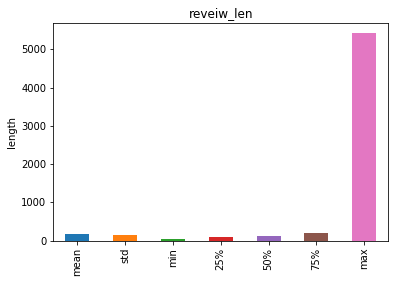

In [18]:
import matplotlib.pyplot as plt
print('reveiw_len < 40 :',len(p_train_df[p_train_df['reveiw_len']<40]))
print('reveiw_len > 1200 :',len(p_train_df[p_train_df['reveiw_len']>1000])) # # max pos, max_enc_steps 
s = p_train_df['reveiw_len'].describe(); print(s)
s = s.drop(labels = ['count'])
s.plot.bar()
plt.ylabel('length')
plt.title('reveiw_len')
plt.show()

summary_len > 40 : 49
summary_len <= 10 : 33
count    413688.000000
mean         17.584844
std           4.117621
min          10.000000
25%          15.000000
50%          17.000000
75%          20.000000
max          68.000000
Name: summary_len, dtype: float64


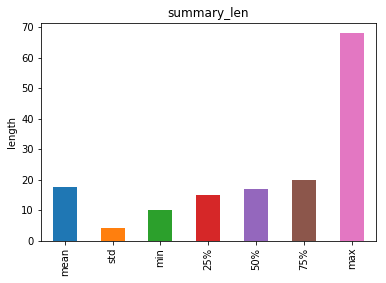

In [10]:
print('summary_len > 40 :',len(p_train_df[p_train_df['summary_len']>40]))  # max_dec_steps
print('summary_len <= 10 :',len(p_train_df[p_train_df['summary_len']<=10])) # min_dec_steps

s = p_train_df['summary_len'].describe(); print(s)
s = s.drop(labels = ['count'])
s.plot.bar()
plt.ylabel('length')
plt.title('summary_len')
plt.show()

# percent_lcs EDA(20 divided)

count    413688.000000
mean         37.759616
std          12.833803
min           4.347826
25%          28.000000
50%          36.842105
75%          47.058824
max          82.051282
Name: percent_lcs, dtype: float64


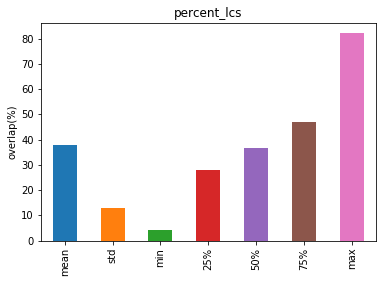

percent_lcs x < 20 :5.83 %
percent_lcs 20 < x < 40 :49.65 %
percent_lcs 40 < x < 60 :34.19 %
percent_lcs 60 < x < 80 :4.56 %
percent_lcs x > 80  :0.00 %


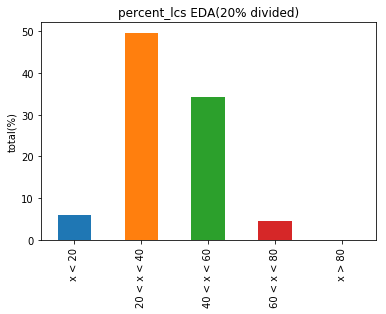

In [11]:
# 统计学上的四分为函数
# 原则上p是可以取0到1之间的任意值的。但是有一个四分位数是p分位数中较为有名的。

# 所谓四分位数；即把数值由小到大排列并分成四等份，处于三个分割点位置的数值就是四分位数。

# 第1四分位数 (Q1)，又称“较小四分位数”，等于该样本中所有数值由小到大排列后第25%的数字。
# 第2四分位数 (Q2)，又称“中位数”，等于该样本中所有数值由小到大排列后第50%的数字。
# 第3四分位数 (Q3)，又称“较大四分位数”，等于该样本中所有数值由小到大排列后第75%的数字。
# 第3四分位数与第1四分位数的差距又称四分位距（InterQuartile Range,IQR）

s = p_train_df['percent_lcs'].describe(); print(s)
s = s.drop(labels = ['count'])
s.plot.bar()
plt.ylabel('overlap(%)')
plt.title('percent_lcs')
plt.show()

print('percent_lcs x < 20 :%.2f' % float(len(p_train_df[p_train_df['percent_lcs']<20])/len(p_train_df)*100),'%' )  # overlap percent with summary
print('percent_lcs 20 < x < 40 :%.2f' % float( \
      len(p_train_df[(p_train_df['percent_lcs']>20) & (p_train_df['percent_lcs']<40)])/len(p_train_df)*100),'%')  # max_dec_steps
print('percent_lcs 40 < x < 60 :%.2f' % float( \
      len(p_train_df[(p_train_df['percent_lcs']>40) & (p_train_df['percent_lcs']<60)])/len(p_train_df)*100),'%')  # max_dec_steps
print('percent_lcs 60 < x < 80 :%.2f' % float( \
      len(p_train_df[(p_train_df['percent_lcs']>60) & (p_train_df['percent_lcs']<80)])/len(p_train_df)*100),'%')  # max_dec_steps
print('percent_lcs x > 80  :%.2f' % float( \
      len(p_train_df[(p_train_df['percent_lcs']>80)])/len(p_train_df)*100),'%')  # max_dec_steps


s = pd.Series({'x < 20':len(p_train_df[p_train_df['percent_lcs']<20])/len(p_train_df)*100, 
           '20 < x < 40':len(p_train_df[(p_train_df['percent_lcs']>20) & (p_train_df['percent_lcs']<40)])/len(p_train_df)*100, 
           '40 < x < 60':len(p_train_df[(p_train_df['percent_lcs']>40) & (p_train_df['percent_lcs']<60)])/len(p_train_df)*100, 
           '60 < x < 80':len(p_train_df[(p_train_df['percent_lcs']>60) & (p_train_df['percent_lcs']<80)])/len(p_train_df)*100, 
           'x > 80':len(p_train_df[p_train_df['percent_lcs']>80])/len(p_train_df)*100          
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('percent_lcs EDA(20% divided)')
plt.show()

In [12]:
'''
overlap => lcs > (20% summary len)
overlap_pos : 0 Top
overlap_pos : 1 Final
overlap_pos : 2 Other Pos
overlap_pos : -1 No overlap
'''

# print('overlap Top : %2.2f'% float(len(p_train_df[p_train_df['overlap_pos'] == 0])/len(p_train_df)*100),'%') 
# print('overlap Final :%2.2f'% float(len(p_train_df[p_train_df['overlap_pos'] == 1])/len(p_train_df)*100),'%') 
# print('overlap Other Pos :%2.2f'% float(len(p_train_df[p_train_df['overlap_pos'] == 2])/len(p_train_df)*100),'%')
# print('No overlap :%2.2f'% float(len(p_train_df[p_train_df['overlap_pos'] == -1])/len(p_train_df)*100),'%') 

# s = pd.Series({'overlap Top':len(p_train_df[p_train_df['overlap_pos'] == 0])/len(p_train_df)*100, 
#            'overlap Final':len(p_train_df[p_train_df['overlap_pos'] == 1])/len(p_train_df)*100, 
#            'overlap Other Pos':len(p_train_df[p_train_df['overlap_pos'] == 2])/len(p_train_df)*100, 
#            'No overlap':len(p_train_df[p_train_df['overlap_pos'] == -1])/len(p_train_df)*100, 
#           })
# print(s)
# s.plot.bar()
# plt.ylabel('overlap(%)')
# plt.title('percent_lcs')
# plt.show()

'\noverlap => lcs > (20% summary len)\noverlap_pos : 0 Top\noverlap_pos : 1 Final\noverlap_pos : 2 Other Pos\noverlap_pos : -1 No overlap\n'

# Ext/Abs分界(50)

percent_lcs x > 50  17.01 %
percent_lcs x <= 50  82.99 %


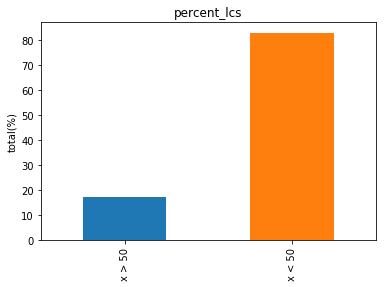

In [13]:
print('percent_lcs x > 50  %2.2f'% float(len(p_train_df[(p_train_df['percent_lcs']>50)])/len(p_train_df)*100),'%')  # max_dec_steps
print('percent_lcs x <= 50  %2.2f'% float(len(p_train_df[(p_train_df['percent_lcs']<=50)])/len(p_train_df)*100),'%')  # max_dec_steps

s = pd.Series({'x > 50':len(p_train_df[(p_train_df['percent_lcs']>50)])/len(p_train_df)*100, 
           'x < 50':len(p_train_df[(p_train_df['percent_lcs']<=50)])/len(p_train_df)*100,      
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('percent_lcs')
plt.show()

overlap Top :4.00 %
overlap Final :0.00 %
overlap Other Pos :13.02 %
No overlap :82.99 %


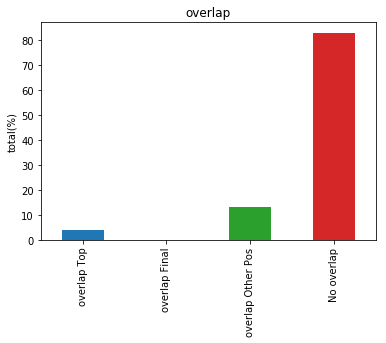

In [14]:
'''
overlap => lcs > (20% summary len)
overlap_pos : 0 Top
overlap_pos : 1 Final
overlap_pos : 2 Other Pos
overlap_pos : -1 No overlap
'''

print('overlap Top :%2.2f'% float(len(p_train_df[(p_train_df['overlap_pos'] == 0) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100),'%') 
print('overlap Final :%2.2f'% float(len(p_train_df[(p_train_df['overlap_pos'] == 1) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100),'%') 
print('overlap Other Pos :%2.2f'% float(len(p_train_df[(p_train_df['overlap_pos'] == 2) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100),'%') 
print('No overlap :%2.2f'% float(len(p_train_df[(p_train_df['percent_lcs']<=50)])/len(p_train_df)*100),'%') 

s = pd.Series({'overlap Top':len(p_train_df[(p_train_df['overlap_pos'] == 0) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100, 
           'overlap Final':len(p_train_df[(p_train_df['overlap_pos'] == 1) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100,      
           'overlap Other Pos':len(p_train_df[(p_train_df['overlap_pos'] == 2) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100,  
           'No overlap':len(p_train_df[(p_train_df['percent_lcs']<=50)])/len(p_train_df)*100,  
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('overlap')
plt.show()

In [15]:
def view(df, condition, view_num=10):
    package_dict = []
    for i in range(view_num):
        d1 = dict(p_train_df[eval(condition)].iloc[i])
        d2 = {'review':d1['review'],
              'summary':d1['summary'],
              'token_lcs':d1['token_lcs'],
              'overlap':d1['overlap'],
              'percent_lcs':d1['percent_lcs'],
             }
        package_dict.append(d2)
    return package_dict
        
# view(p_train_df, "(p_train_df['overlap_pos'] == 2) & (p_train_df['percent_lcs']>50)")
view(p_train_df, "(p_train_df['summary_len']<11)")

[{'review': 'for outdoor basketball grip durability and balance are probably the most important consideration . street basketball rank pretty high those key department . you get nice firm grip the durability the pebble finish seem pretty good and you get nice bounce various type hardcourt . the grip may not good nba legacy ball but very close . like many outdoor type ball may feel little heavy indoor court . reasonably price you need outdoor ball you really wrong with this one .',
  'summary': '<s> good outdoor ball </s>',
  'token_lcs': 'outdoor ball ball ',
  'overlap': 3,
  'percent_lcs': 30.0},
 {'review': 'look like phone are similar car that you get bad one you get bad one and you get good one you get good one . get good one . had commando for couple month . buy verizon store with final new every two credit walk out the store with this new phone for 100 . previous this had type then rock and then original motorola droid . buy verizon store with final new every two credit walk out

In [16]:
dict(p_train_df[(p_train_df['overlap_pos'] == 2) & (p_train_df['percent_lcs']>50)].iloc[0:10])['summary']

402696    <s> we try the magnum original and they were h...
102418    <s> the remote is not backlit so you better me...
448904    <s> and the salmon and shrimp every day and re...
85492     <s> really like them but this package had coup...
210499    <s> am not an experienced snorkeler but with t...
397319    <s> this unit is clearer and the sound is bett...
112019    <s> buy this camera for the zoom and it is ama...
92972     <s> hand down the best battery pack for the zo...
232162    <s> it is just cheap clone of better machete l...
239381    <s> legging for two year now and love them the...
Name: summary, dtype: object